
--- Analysis Summary ---
-------------------------------------------------------
Parameter                                | Value        
-------------------------------------------------------
--- Input Parameters ---
Input File                               | trajectory_prod_gpu.lammpstrj
Averaged Frames (Last N)                 | 20           
DBSCAN eps (Å)                           | 5.0          
DBSCAN min_samples                       | 5            
Density Bin Size (Å)                     | 0.75         
Gaussian Sigma (bins)                    | 1.2          
Contact Angle Density Level (g/cm³)      | 0.50         
Contact Angle Substrate Z (Å)            | 30.00        
--- Droplet Properties ---
Processed Frames Count                   | 20           
Total Oxygen Points Used                 | 178700       
Max Smoothed Density (g/cm³)             | 1.0482       
Droplet Thickness (Y) (Å)                | 85.57        
Droplet Height (Z) (Å)                   | 79.33     

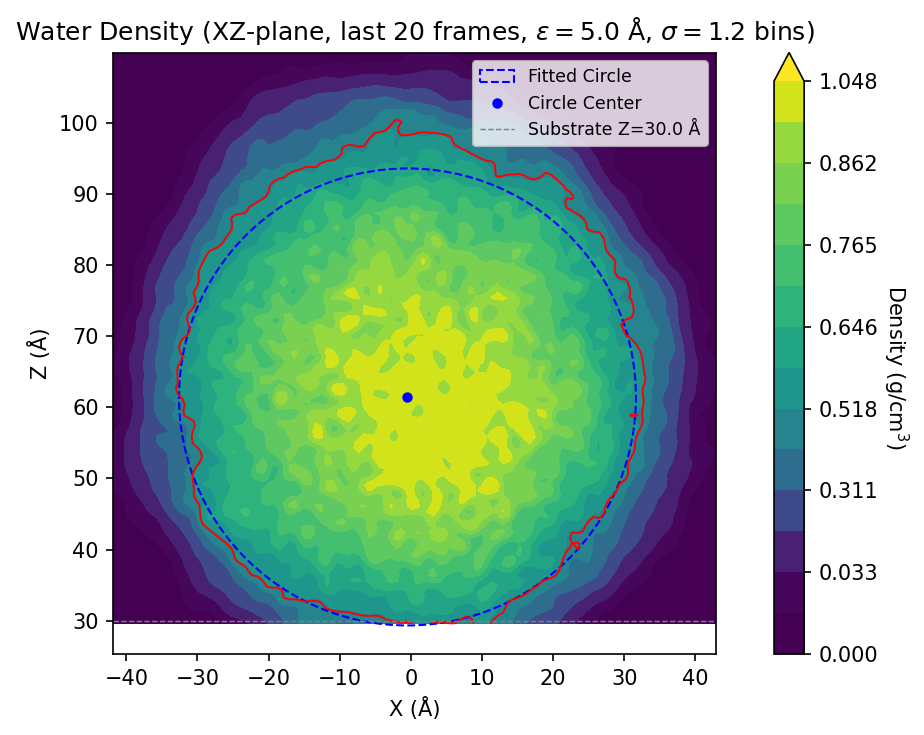

In [18]:
import numpy as np
from sklearn.cluster import DBSCAN
from scipy.ndimage import gaussian_filter
from scipy.optimize import least_squares
import matplotlib.pyplot as plt
import math
import sys
import os
import traceback # For detailed error printing

# --- Analysis Parameters ---
file_path = "/mnt/c/Users/vbarv/Desktop/course/project/lammps/output/trajectory_prod_gpu.lammpstrj" # Path to LAMMPS trajectory file
#file_path = "/mnt/c/Users/vbarv/Desktop/course/project/lammps/LIPSS.lammpstrj"

output_dir = os.path.dirname(file_path) # Directory to save plot
plot_filename = "density_profile_final.png" # Output plot filename

# Frame Selection
Nframes = 20        # Number of last frames to average for analysis

# Atom Types (Consistent with LAMMPS data)
oxygen_type = 1     # Atom type ID for Oxygen atoms

# Clustering Parameters (DBSCAN)
eps = 5           # DBSCAN distance threshold (Angstrom)
min_samples = 5     # DBSCAN minimum neighbors

# Density Calculation Parameters
bin_size = 0.75     # Grid bin size (Angstrom) for density histogram
sigma = 1.2         # Gaussian smoothing sigma (in bins)

# Contact Angle Calculation Parameters
contact_density = 0.5 # Density level for contour (g/cm^3)
substrate_z = 30     # Effective substrate Z-level (Angstrom)

# --- Constants ---
mass_h2o_amu = 18.015 # Mass of a water molecule (amu)
amu_to_g = 1.66054e-24 # amu to gram conversion
angstrom3_to_cm3 = 1e-24 # Angstrom^3 to cm^3 conversion


# --- Core Functions ---
def read_lammps_trajectory_frames(filepath, num_last_frames):
    """
    Reads the entire LAMMPS trajectory file (.lammpstrj), identifies frame
    start indices, and returns lines plus indices for the last N frames.
    """
    with open(filepath, 'r') as f:
        lines = f.readlines()

    # Find lines marking the start of each frame
    frame_start_indices = [i for i, line in enumerate(lines) if line.strip() == "ITEM: TIMESTEP"]
    total_frames = len(frame_start_indices)

    # Adjust Nframes if necessary
    if num_last_frames > total_frames:
        print(f"Warning: Requested {num_last_frames} frames, but only {total_frames} available. Using all available.")
        num_last_frames = total_frames
    if num_last_frames <= 0:
         raise ValueError(f"Nframes ({num_last_frames}) must be positive.")

    # Select the starting line indices for the last N frames
    start_indices = frame_start_indices[-num_last_frames:]
    return lines, start_indices, num_last_frames


def parse_frame_header(lines, frame_idx):
    """
    Parses Number of Atoms and Box Bounds from the header of a specific frame.
    """
    num_atoms = None
    box = None
    try:
        # Expect Number of Atoms at line index frame_idx + 3
        num_atoms = int(lines[frame_idx + 3].strip())
        if num_atoms <= 0: raise ValueError("Number of atoms is non-positive.")

        # Find ITEM: BOX BOUNDS, allowing for slight variations in spacing
        box_bounds_idx = -1
        for i in range(frame_idx + 4, min(frame_idx + 10, len(lines))): # Search few lines
             if lines[i].startswith("ITEM: BOX BOUNDS"):
                  box_bounds_idx = i
                  break
        if box_bounds_idx == -1: raise IndexError("ITEM: BOX BOUNDS not found near expected position.")

        # Expect box bounds data on the next 3 lines
        x_line = lines[box_bounds_idx + 1].split(); y_line = lines[box_bounds_idx + 2].split(); z_line = lines[box_bounds_idx + 3].split()
        if len(x_line)!=2 or len(y_line)!=2 or len(z_line)!=2: raise ValueError("Box bounds format error (expected 2 values per line)")

        # Store box info
        box = {'xlo': float(x_line[0]), 'xhi': float(x_line[1]),
               'ylo': float(y_line[0]), 'yhi': float(y_line[1]),
               'zlo': float(z_line[0]), 'zhi': float(z_line[1])}
        box['Lx'] = box['xhi'] - box['xlo']
        box['Ly'] = box['yhi'] - box['ylo']
        box['Lz'] = box['zhi'] - box['zlo']
        # Sanity check box dimensions
        if box['Lx'] <= 0 or box['Ly'] <= 0 or box['Lz'] <= 0: raise ValueError("Box dimensions non-positive.")

    except Exception as e:
        print(f"  ERROR reading header for frame {frame_idx}: {e}. Skipping frame.")
        return None, None # Return None if any part fails
    return num_atoms, box


def find_and_parse_atom_header(lines, start_search_idx, end_search_idx):
    """
    Finds the 'ITEM: ATOMS' line within the frame data section and parses
    """
    atom_section_idx = start_search_idx
    max_search = min(end_search_idx, start_search_idx + 30) # Limit search range

    while atom_section_idx < max_search:
        # Check for premature start of the next frame
        if lines[atom_section_idx].strip().startswith("ITEM: TIMESTEP"):
             raise ValueError("'ITEM: ATOMS' not found before next TIMESTEP.")
        # Check for the target header line
        if lines[atom_section_idx].strip().startswith("ITEM: ATOMS"):
            try:
                header_line = lines[atom_section_idx].strip()
                header_parts = header_line.split()[2:] # Skip "ITEM:", "ATOMS"
                # Check for required columns (expecting scaled coordinates)
                required_cols = ["type", "xs", "ys", "zs"]
                if not all(col in header_parts for col in required_cols):
                    missing = [c for c in required_cols if c not in header_parts]
                    raise ValueError(f"Header '{header_line}' missing required columns: {missing}. Found: {header_parts}")
                # Get indices
                col_indices = {col: header_parts.index(col) for col in required_cols}
                return atom_section_idx, col_indices # Success
            except Exception as e:
                # Error during parsing of the found line
                raise ValueError(f"Error parsing atom header line {atom_section_idx} ('{header_line}'): {e}")
        atom_section_idx += 1 # Move to next line

    # If loop finishes without finding the header
    raise ValueError(f"'ITEM: ATOMS' not found between lines {start_search_idx} and {max_search}")


def extract_unscaled_coords(lines, start_line, num_atoms, col_indices, atom_filter_type, box):
    """
    Extracts coordinates for atoms of atom_filter_type from atom data lines,
    unscaling them using the provided box dimensions.
    """
    coords = []
    skipped_lines = 0
    end_line = min(start_line + num_atoms, len(lines))
    min_cols = max(col_indices.values()) + 1 # Minimum columns needed based on indices

    for i in range(start_line, end_line):
        parts = lines[i].strip().split()
        if not parts: continue # Skip empty lines

        # Check if line has enough columns before trying to access indices
        if len(parts) < min_cols:
            print(f"  Warning: Skipping malformed atom line {i+1} (only {len(parts)} columns): {lines[i].strip()}")
            skipped_lines += 1
            continue

        try:
            # Check type first for efficiency
            if int(parts[col_indices["type"]]) == atom_filter_type:
                # Extract scaled coordinates
                xs = float(parts[col_indices["xs"]])
                ys = float(parts[col_indices["ys"]])
                zs = float(parts[col_indices["zs"]])
                # Unscale coordinates
                x = box['xlo'] + xs * box['Lx']
                y = box['ylo'] + ys * box['Ly']
                z = box['zlo'] + zs * box['Lz']
                coords.append([x, y, z])
        except (ValueError, IndexError) as e:
            # Catch errors during type/coordinate conversion or indexing
            print(f"  Warning: Skipping atom line {i+1} due to parsing error ({e}): {lines[i].strip()}")
            skipped_lines += 1
            continue # Skip this line

    if skipped_lines > 0:
         print(f"  Finished extracting coordinates, skipped {skipped_lines} lines due to errors.")
    return np.array(coords)


def get_main_droplet_cluster(coords, eps, min_samples):
    """
    Identifies the largest cluster in the provided coordinates using DBSCAN.
    """
    # Check if enough points exist for clustering
    if coords.shape[0] < min_samples:
        print(f"  Warning: Only {coords.shape[0]} points found, less than min_samples={min_samples} required for DBSCAN.")
        return None

    try:
        # Perform DBSCAN clustering
        clustering = DBSCAN(eps=eps, min_samples=min_samples)
        labels = clustering.fit_predict(coords)
        unique_labels, counts = np.unique(labels, return_counts=True)
    except Exception as e:
        print(f"  ERROR during DBSCAN execution: {e}")
        return None

    # Find the largest cluster excluding noise (label -1)
    main_label = -1
    max_count = 0
    noise_count = counts[unique_labels == -1][0] if -1 in unique_labels else 0

    for lab, count in zip(unique_labels, counts):
        if lab == -1: continue # Skip noise
        if count > max_count:
            max_count = count
            main_label = lab

    # Check if a valid cluster was found
    if main_label == -1:
        print(f"  Warning: DBSCAN did not find a main cluster (noise points: {noise_count}). Labels found: {unique_labels}, Counts: {counts}")
        return None # No dominant non-noise cluster

    # Return coordinates belonging to the largest cluster
    return coords[labels == main_label]


def calculate_density_profile(all_coords_x, all_coords_y, all_coords_z, bin_size, sigma, n_avg_frames, substrate_z):
    """
    Calculates the 2D density profile in the XZ plane, averaged over frames.
    """
    if not isinstance(all_coords_x, list) or not all_coords_x:
         raise ValueError("Input coordinate lists are empty or invalid for density calculation.")

    # Calculate overall bounds from aggregated coordinates
    try:
        x_min, x_max = min(all_coords_x), max(all_coords_x)
        y_min, y_max = min(all_coords_y), max(all_coords_y)
        z_min, z_max = min(all_coords_z), max(all_coords_z)
    except ValueError:
         raise ValueError("Could not determine min/max from coordinate lists (possibly empty).")

    # Calculate derived properties
    thickness = y_max - y_min
    height = z_max - substrate_z # Height relative to defined substrate level
    base_width = x_max - x_min   # Base width in X (after centering)
    if thickness <= 1e-6: raise ValueError(f"Calculated droplet thickness ({thickness:.2f}) is too small.")

    # Define histogram grid with padding
    x_min_grid = x_min - bin_size; x_max_grid = x_max + bin_size
    z_min_grid = max(substrate_z - bin_size, z_min - bin_size) # Ensure grid starts near substrate
    z_max_grid = z_max + bin_size
    x_bins = np.arange(x_min_grid, x_max_grid + bin_size, bin_size)
    z_bins = np.arange(z_min_grid, z_max_grid + bin_size, bin_size)
    if len(x_bins) <= 1 or len(z_bins) <= 1:
        raise ValueError(f"Invalid grid dimensions created. Check bounds and bin size. x_bins: {len(x_bins)}, z_bins: {len(z_bins)}")

    # Calculate 2D histogram (counts of oxygen atoms in each XZ bin)
    H, z_edges, x_edges = np.histogram2d(all_coords_z, all_coords_x, bins=[z_bins, x_bins])

    # Average counts over the number of successfully processed frames
    if n_avg_frames <= 0: raise ValueError("Number of averaged frames must be positive.")
    H_avg = H / n_avg_frames

    # Calculate mass density
    mass_per_water_g = mass_h2o_amu * amu_to_g
    # Calculate bin volume using the overall droplet thickness (approximation)
    bin_volume_cm3 = (bin_size ** 2) * thickness * angstrom3_to_cm3
    if bin_volume_cm3 <= 1e-30: raise ValueError("Calculated bin volume is zero or negative.") # Added check
    density = H_avg * mass_per_water_g / bin_volume_cm3 # g/cm^3

    # Apply Gaussian smoothing
    density_smooth = gaussian_filter(density, sigma=sigma)

    # Prepare outputs
    x_centers = 0.5 * (x_edges[:-1] + x_edges[1:])
    z_centers = 0.5 * (z_edges[:-1] + z_edges[1:])
    properties = {'thickness': thickness, 'height': height, 'base_width': base_width,
                  'x_min': x_min, 'x_max': x_max, 'y_min': y_min, 'y_max': y_max,
                  'z_min': z_min, 'z_max': z_max, 'max_density': np.max(density_smooth)} # Use smoothed max density

    return x_centers, z_centers, density_smooth, properties


def fit_circle_least_squares(x, z):
    """
    Fits a circle to X, Z data points using least squares ('trf' method).
    """
    coords = np.vstack([x, z]).T
    if coords.shape[0] < 3:
        print("  Warning: Need at least 3 points for circle fitting.")
        return None, None, None # Need minimum 3 points to define a circle

    # Provide robust initial estimates for center (median) and radius
    center_estimate = np.median(coords, axis=0) # Use median for robustness
    radius_estimate = np.median(np.sqrt(((coords - center_estimate)**2).sum(axis=1)))
    # Ensure radius estimate is positive
    if radius_estimate < 1e-6: radius_estimate = 1.0 # Fallback if points are collinear

    # Residual function: geometric distance - R
    def residuals(params, x, z):
        xc, zc, R = params
        # R is constrained by bounds now, no need for penalty here
        dist_sq = (x - xc)**2 + (z - zc)**2
        # Handle potential negative values due to numerical issues before sqrt
        dist = np.sqrt(np.maximum(dist_sq, 0))
        return dist - R

    params0 = [center_estimate[0], center_estimate[1], radius_estimate]
    try:
        # Use 'trf' method which supports bounds
        result = least_squares(residuals, params0, args=(x, z), method='trf',
                               bounds=([-np.inf, -np.inf, 1e-6], [np.inf, np.inf, np.inf])) # R > 0 bound

        if result.success:
            xc, zc, R = result.x
            # Final check on radius validity
            if R > 1e-6:
                return xc, zc, R
            else:
                 print(f"  Warning: Circle fitting converged but radius is non-positive (R={R:.3f}).")
                 return None, None, None
        else:
            print(f"  Warning: Circle fitting optimization did not converge (Status: {result.status}, Message: {result.message}).")
            return None, None, None
    except Exception as e:
        print(f"  ERROR during circle fitting optimization: {e}")
        return None, None, None


def calculate_contact_angle(x_centers, z_centers, density_map, density_level, substrate_level, fit_region='lower'):
    """
    Calculates contact angle by fitting a circle to a specified density contour.
    """
    contact_angle, xc, zc, R = np.nan, np.nan, np.nan, np.nan # Initialize results

    fig_temp, ax_temp = plt.subplots() # Create temporary figure/axes for contour finding
    try:
        # 1. Determine density map orientation for plotting functions
        if density_map.shape == (len(z_centers), len(x_centers)):
            density_for_contour = density_map
            # print("  DEBUG: Using density_map for contour.")
        elif density_map.T.shape == (len(z_centers), len(x_centers)):
            density_for_contour = density_map.T
            # print("  DEBUG: Using density_map.T for contour.")
        else:
            raise ValueError(f"Density map shape {density_map.shape} mismatch for contour with axes lengths Z:{len(z_centers)}, X:{len(x_centers)}.")

        # 2. Extract contour vertices at the specified density level
        contours = ax_temp.contour(x_centers, z_centers, density_for_contour, levels=[density_level])

        contour_segments = []
        if hasattr(contours, 'allsegs') and len(contours.allsegs) > 0:
             contour_segments = contours.allsegs[0] # Data for the first (only) level

        if not contour_segments:
             print(f"  Warning: No contour segments found at density level {density_level}. Cannot calculate angle.")
             return contact_angle, xc, zc, R # Return NaNs

        # Combine all segments into one array of vertices
        all_vertices = np.vstack(contour_segments)
        contour_x_all = all_vertices[:, 0]
        contour_z_all = all_vertices[:, 1]

        # 3. Select points for circle fitting based on fit_region
        if fit_region == 'lower':
            # Estimate center Z using median of all contour points
            zc_est = np.median(contour_z_all) if len(contour_z_all) > 0 else substrate_level
            # Select points below the estimated center and slightly above substrate
            valid_indices = (contour_z_all < zc_est) & (contour_z_all > (substrate_level + 0.5 * bin_size))
            x_fit = contour_x_all[valid_indices]
            z_fit = contour_z_all[valid_indices]
        elif fit_region == 'all':
             x_fit = contour_x_all
             z_fit = contour_z_all
        else:
            raise ValueError(f"Unknown fit_region: '{fit_region}'. Choose 'lower' or 'all'.")

        # 4. Fit circle to selected points
        if len(x_fit) > 10: # Need enough points for a reliable fit
            xc, zc, R = fit_circle_least_squares(x_fit, z_fit)
        else:
            print("  Warning: Not enough points selected for reliable circle fit.")
            # Leave xc, zc, R as NaN

        # 5. Calculate contact angle using parameters from the fit
        if R is not None and not np.isnan(R) and R > 0:
            # Check geometric condition for intersection
            if abs(zc - substrate_level) < R:
                # Calculate argument for asin, clamp to avoid domain errors
                arg = (zc - substrate_level) / R
                arg = max(-1.0, min(1.0, arg))
                # Calculate angle in degrees
                angle_rad = math.asin(arg)
                contact_angle = 90.0 + math.degrees(angle_rad)
            else:
                 # Circle fit succeeded but doesn't intersect the substrate level
                 print(f"  Warning: Fitted circle (Zc={zc:.2f}, R={R:.2f}) does not intersect substrate Z={substrate_level:.2f}. Cannot calculate angle.")
                 contact_angle = np.nan # Ensure angle is NaN
        else:
             # Circle fit failed or returned invalid radius
             print("  Contact angle calculation skipped due to failed/invalid circle fit.")
             contact_angle = np.nan # Ensure angle is NaN

    except Exception as e:
        print(f"  ERROR during contact angle calculation steps: {e}")
        traceback.print_exc() # Print full traceback for debugging
        contact_angle, xc, zc, R = np.nan, np.nan, np.nan, np.nan # Ensure NaNs on error
    finally:
        plt.close(fig_temp) # Ensure temporary figure is always closed

    # Return results (angle might be nan, circle params might be nan)
    return contact_angle, xc, zc, R


def print_summary_table(properties):
    """Prints a formatted table of analysis results, including input parameters."""
    print("\n--- Analysis Summary ---")
    print("-" * 55)
    print(f"{'Parameter':<40} | {'Value':<13}")
    print("-" * 55)
    # Helper to format numbers or print N/A
    def fmt(val, f):
        # Check for None or NaN explicitly
        is_invalid = val is None or (isinstance(val, (float, np.floating)) and np.isnan(val))
        return "N/A" if is_invalid else f"{val:{f}}"

    print("--- Input Parameters ---")
    print(f"{'Input File':<40} | {os.path.basename(properties.get('file_path', 'N/A')):<13}")
    print(f"{'Averaged Frames (Last N)':<40} | {fmt(properties.get('Nframes'), '<13d')}")
    print(f"{'DBSCAN eps (Å)':<40} | {fmt(properties.get('eps'), '<13.1f')}")
    print(f"{'DBSCAN min_samples':<40} | {fmt(properties.get('min_samples'), '<13d')}")
    print(f"{'Density Bin Size (Å)':<40} | {fmt(properties.get('bin_size'), '<13.2f')}")
    print(f"{'Gaussian Sigma (bins)':<40} | {fmt(properties.get('sigma'), '<13.1f')}")
    print(f"{'Contact Angle Density Level (g/cm³)':<40} | {fmt(properties.get('contact_density'), '<13.2f')}")
    print(f"{'Contact Angle Substrate Z (Å)':<40} | {fmt(properties.get('substrate_z'), '<13.2f')}")
    print("--- Droplet Properties ---")
    print(f"{'Processed Frames Count':<40} | {fmt(properties.get('processed_frames'), '<13d')}")
    print(f"{'Total Oxygen Points Used':<40} | {fmt(properties.get('total_points'), '<13d')}")
    print(f"{'Max Smoothed Density (g/cm³)':<40} | {fmt(properties.get('max_density'), '<13.4f')}")
    print(f"{'Droplet Thickness (Y) (Å)':<40} | {fmt(properties.get('thickness'), '<13.2f')}")
    print(f"{'Droplet Height (Z) (Å)':<40} | {fmt(properties.get('height'), '<13.2f')}")
    print(f"{'Droplet Base Width (X) (Å)':<40} | {fmt(properties.get('base_width'), '<13.2f')}")
    print("--- Fit Results ---")
    print(f"{'Fitted Circle Center Xc (Å)':<40} | {fmt(properties.get('Circle Xc'), '<13.2f')}")
    print(f"{'Fitted Circle Center Zc (Å)':<40} | {fmt(properties.get('Circle Zc'), '<13.2f')}")
    print(f"{'Fitted Circle Radius R (Å)':<40} | {fmt(properties.get('Circle R'), '<13.2f')}")
    print(f"{'Contact Angle (°)':<40} | {fmt(properties.get('Contact Angle'), '<13.2f')}")
    print("-" * 55)


def plot_density_profile(x_centers, z_centers, density_map, plot_properties):
    """Generates and saves the 2D density contour plot."""
    fig, ax = plt.subplots(figsize=(8, 5), dpi=150) # Adjust dpi if needed

    # Determine plot orientation
    density_to_plot, orientation_note = None, " N/A"
    try:
        if density_map.shape == (len(z_centers), len(x_centers)):
            density_to_plot = density_map; orientation_note = " (Z vs X)"
        elif density_map.T.shape == (len(z_centers), len(x_centers)):
            density_to_plot = density_map.T; orientation_note = " (Z vs X, transposed)"
        else: raise ValueError("Density map shape mismatch")
        print(f"Plotting density data shape {density_to_plot.shape}. Orientation:{orientation_note}")
    except Exception as e:
        print(f"ERROR determining density orientation for plot: {e}"); plt.close(fig); return

    # Calculate contour levels based on density range
    max_density = plot_properties.get('max_density', 0.0)
    if max_density > 1e-9:
        valid_density_values = density_to_plot[density_to_plot > 1e-6]
        if len(valid_density_values) > 0:
             levels = np.percentile(valid_density_values, np.linspace(0, 100, 15)) # Increased levels
             levels = np.unique(np.round(np.insert(levels, 0, 0), 4)) # Add 0 level, round, ensure unique
             if len(levels) < 2: levels = np.linspace(0, max_density, 7) # Fallback
        else: levels = np.linspace(0, max_density, 7)
    else: levels = [0, 1e-9]

    # Create the plots
    try:
        # Filled contour plot for density
        contour = ax.contourf(x_centers, z_centers, density_to_plot, levels=levels, cmap='viridis', extend='max')

        # Add contour line at the specified contact_density
        cont_dens = plot_properties.get('contact_density', 0.5)
        if max_density > cont_dens:
             ax.contour(x_centers, z_centers, density_to_plot, levels=[cont_dens], colors='red', linewidths=0.9, linestyles='solid')

        # Add fitted circle if calculated successfully
        xc_plot, zc_plot, R_plot = plot_properties.get('Circle Xc', np.nan), plot_properties.get('Circle Zc', np.nan), plot_properties.get('Circle R', np.nan)
        if not np.isnan(R_plot) and R_plot > 0:
            circle = plt.Circle((xc_plot, zc_plot), R_plot, color='blue', fill=False, linestyle='--', linewidth=1.0, label='Fitted Circle')
            ax.add_patch(circle)
            ax.plot(xc_plot, zc_plot, 'bo', markersize=4, label='Circle Center') # Mark center
            ax.legend(fontsize='small') # Add legend if circle is plotted

    except Exception as e:
         print(f"ERROR during plotting contours or circle: {e}")
         traceback.print_exc()
         plt.close(fig)
         return

    # Setup plot aesthetics
    nframes_plot = plot_properties.get('Nframes', '?')
    eps_plot = plot_properties.get('eps', '?')
    sigma_plot = plot_properties.get('sigma', '?')
    ax.set_title(f"Water Density (XZ-plane, last {nframes_plot} frames, $\\epsilon={eps_plot:.1f}$ Å, $\\sigma={sigma_plot:.1f}$ bins)")
    ax.set_xlabel("X (Å)")
    ax.set_ylabel("Z (Å)")
    ax.set_aspect('equal', adjustable='box') # Crucial for correct shape perception
    # Add substrate line using the value from properties
    sub_z_plot = plot_properties.get('substrate_z', 0.0)
    ax.axhline(sub_z_plot, color='grey', linestyle='--', linewidth=0.7, label=f'Substrate Z={sub_z_plot:.1f} Å')
    if 'substrate_z' in plot_properties: ax.legend(fontsize='small') # Add legend if substrate line is plotted

    # Add colorbar
    cbar = fig.colorbar(contour)
    cbar.set_label("Density (g/cm$^3$)", rotation=270, labelpad=15)

    plt.tight_layout() # Adjust layout

    # Save plot to file
    output_plot_path = os.path.join(plot_properties.get('output_dir', '.'), plot_filename)
    try:
        plt.savefig(output_plot_path, dpi=300, bbox_inches='tight') # Use bbox_inches='tight'
    except Exception as e:
        print(f"ERROR saving plot to {output_plot_path}: {e}")
    plt.show() # Display plot


# --- Main Execution Block ---
if __name__ == "__main__":

    # Store parameters for summary
    analysis_params = {
        'file_path': file_path, 'Nframes': Nframes, 'oxygen_type': oxygen_type,
        'eps': eps, 'min_samples': min_samples, 'bin_size': bin_size,
        'sigma': sigma, 'contact_density': contact_density, 'substrate_z': substrate_z,
        'output_dir': output_dir
    }

    # 1. Read trajectory
    lines, frame_indices, Nframes_actual = read_lammps_trajectory_frames(file_path, Nframes)
    analysis_params['Nframes'] = Nframes_actual # Update with actual number used

    # 2. Process frames
    all_X, all_Y, all_Z = [], [], []
    processed_frames_count = 0
    for i, idx in enumerate(frame_indices):
        num_atoms, box_info = parse_frame_header(lines, idx)
        if num_atoms is None or box_info is None: continue

        start_atom_search_line = idx + 8 # Expect ATOMS header after box bounds data
        end_atom_search_line = frame_indices[i+1] if i+1 < len(frame_indices) else len(lines)

        try:
            atom_section_start_idx, column_indices = find_and_parse_atom_header(lines, start_atom_search_line, end_atom_search_line)
        except ValueError as e: print(f"  ERROR finding/parsing ATOMS header: {e}. Skipping frame."); continue

        oxygen_coords_unscaled = extract_unscaled_coords(lines, atom_section_start_idx + 1, num_atoms, column_indices, oxygen_type, box_info)
        if oxygen_coords_unscaled.shape[0] == 0: print("  No oxygen atoms found/extracted. Skipping frame."); continue

        droplet_coords = get_main_droplet_cluster(oxygen_coords_unscaled, eps, min_samples)
        if droplet_coords is None: print("  No main droplet cluster identified. Skipping frame."); continue

        com_x = droplet_coords[:, 0].mean(); droplet_coords[:, 0] -= com_x # Center X
        all_X.extend(droplet_coords[:, 0].tolist()); all_Y.extend(droplet_coords[:, 1].tolist()); all_Z.extend(droplet_coords[:, 2].tolist())
        processed_frames_count += 1


    # Check if any frames were processed successfully
    if processed_frames_count == 0 or len(all_X) == 0:
        raise ValueError("No frames processed successfully or no droplet data collected.")

    # 3. Calculate density profile (and onwards)
    if processed_frames_count > 0 and len(all_X) > 0:
        try:
            x_centers, z_centers, density_smooth, droplet_props = calculate_density_profile(
                all_X, all_Y, all_Z, bin_size, sigma, processed_frames_count, substrate_z
            )
        except Exception as e:
            print(f"\nERROR calculating density profile: {e}")
            sys.exit(1)

        # 4. Calculate contact angle
        try:
            contact_angle, xc, zc, R = calculate_contact_angle(
                x_centers, z_centers, density_smooth, contact_density, substrate_z
            )
        except Exception as e:
            print(f"  ERROR during contact angle calculation step: {e}")
            import traceback
            traceback.print_exc()
            contact_angle, xc, zc, R = np.nan, np.nan, np.nan, np.nan

        # 5. Prepare summary data
        summary_data = droplet_props.copy()
        summary_data.update(analysis_params)
        summary_data['processed_frames'] = processed_frames_count
        summary_data['total_points'] = len(all_X)
        summary_data['Contact Angle'] = contact_angle
        summary_data['Circle Xc'] = xc
        summary_data['Circle Zc'] = zc
        summary_data['Circle R'] = R

        # 6. Print Summary Table
        try:
             print_summary_table(summary_data)
        except Exception as e:
             print(f"ERROR occurred INSIDE print_summary_table: {e}")
             traceback.print_exc()

        # 7. Plot Density Profile
        plot_density_profile(x_centers, z_centers, density_smooth, summary_data)


    else:
         print("\nNo frames were successfully processed or no droplet data collected. Cannot proceed.")

